# Starbucks Capstone Challenge

## Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.


To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

## Focus questions

In this project, I set out to achieve the following:

- **Identify the factors that influence the likelihood of a user responding to a buy one get one (BOGO) or discount offer**
- **Create and evaluate a set of heuristics or classification models for identifying user groups that are most responsive to offers**

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [74]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import relativedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK
import kmeans1d

%matplotlib inline
pd.set_option('display.max_columns', 500)

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Preliminary EDA

Understanding what the raw data looks like

In [3]:
# Dataset dimensions
portfolio.shape, profile.shape, transcript.shape

((10, 6), (17000, 5), (306534, 4))

In [4]:
portfolio.sort_values(['offer_type','difficulty','duration'])

,reward,channels,difficulty,duration,offer_type,id
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed


In [5]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [6]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [7]:
#Looking at the types of events
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [8]:
#Looking at the history for one user.
transcript[transcript['person'] == 'fe97aa22dd3e48c8b143116a8403dd52']

,person,event,value,time
107,fe97aa22dd3e48c8b143116a8403dd52,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
15578,fe97aa22dd3e48c8b143116a8403dd52,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},6
24238,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 13.9},30
38230,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 16.99},84
39554,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 13.96},90
53283,fe97aa22dd3e48c8b143116a8403dd52,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},168
79443,fe97aa22dd3e48c8b143116a8403dd52,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},198
79444,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 28.71},198


### Observations

**Offers**

BOGO and Discount will have an offer completed marker. However, as described above, to mark a customer as having been influenced by the offer, we may need to focus on customers that meet the following criteria:

***Receives offer -> Views offer -> Completes offer***


Advertisements will not follow the same flow:

***Receives offer -> Views offer -> Transaction (within effective period of advertisement)***

However, there is no guarantee that the transaction is a direct result of viewing the offer.

**Data**
- The customer and offer ids will need to be converted to something more intuitive. 
- The 'value' column of the transcript dataframe will need to be split into two columns
- The 'time' column of the transcript dataframe will need to be converted from hours to days
- The 'became_member_on' column of the profile dataframe will need to be converted to number of months they have been a member

# Basic Data transformation

The data wrangling to be performed is:
1. Convert customer and offer ids to something more intuitive
2. Split 'value' column of the transcript dataframe into two columns
3. Convert 'time' column of the transcript dataframe from hours into days
4. Convert 'became_member_on' column of the profile dataframe to number of months they have been a member
5. Other misc. data cleaning (duplicate removal, outlier removal etc.)
6. Create a dataframe with the following schema:
    - customer_id - **int**
    - gender - **binary**
    - age - **numeric**
    - months_since_member - Number of months since the customer has become a member - **int**
    - income - **numeric**
    - success_discount - column indicating whether or not the have gone through the process of receiving, viewing and 
      completing a discount offer. 1 or 0 - **int**
    - success_BOGO - column indicating whether or not the have gone through the process of receiving, viewing and 
      completing a BOGO offer. 1 or 0 - **int**
    - success_offer - column indicating if either success_discount or success_BOGO or both columns have a 1. - **int**
    - amount - average amount spent by the user - **numeric**

### Convert 'time' column of the transcript dataframe from hours into days

In [9]:
transcript['time'] = transcript['time']//24 + 1

### Convert 'became_member_on' column of the profile dataframe to number of months they have been a member

In [10]:
def monthsdiff(end_date, start_date):
    """
        Inputs: end_date, start_date
        Outputs: difference between end_date and start_date in months
    """
    diff = relativedelta.relativedelta(end_date, start_date)
    return diff.months + (diff.years * 12)

# Apply a lambda function to transform the became_member_on into datetime data
profile['became_member_on'] = profile['became_member_on'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))

#Create a new column NOM_since_member that represents number of months since they became a member.
#Here the assumption is that the snapshot date is the latest 'became_member_on' date
profile['months_since_member'] = profile['became_member_on'].apply(lambda x: monthsdiff(profile['became_member_on'].max(),x))

In [11]:
profile.head()

,gender,age,id,became_member_on,income,months_since_member
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,17
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,12
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,14
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,11


In [12]:
profile.describe()

,age,income,months_since_member
count,17000.000000,14825.000000,17000.000000
mean,62.531412,65404.991568,16.549706
std,26.738580,21598.299410,13.510550
min,18.000000,30000.000000,0.000000
25%,45.000000,49000.000000,6.000000
50%,58.000000,64000.000000,11.000000
75%,73.000000,80000.000000,26.000000
max,118.000000,120000.000000,59.000000


### Split 'value' column of the transcript dataframe into two columns

In [13]:
# Transform the 'value' column into string and put it into a 'keys_values' column
transcript['keys_values'] = transcript['value'].apply(lambda x: ''.join('{},{}'.format(key, val) for key, val in x.items()))

# Extract the keys and values from the 'keys_values' column and separate them into two columns
transcript['keys'] = transcript['keys_values'].apply(lambda x: x.split(',')[0])
transcript['values'] = transcript['keys_values'].apply(lambda x: x.split(',')[1])

# Drop the value and key_values columns
transcript = transcript.drop(['value', 'keys_values'], axis=1)

In [14]:
transcript.head()

,person,event,time,keys,values
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,1,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,1,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,1,offer id,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,1,offer id,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,1,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0


In [15]:
display(transcript['event'].value_counts(),transcript['keys'].value_counts(),transcript['values'].value_counts())

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

amount      138953
offer id    134002
offer_id     33579
Name: keys, dtype: int64

2298d6c36e964ae4a3e7e9706d1fb8c2    14983
fafdcd668e3743c1bb461111dcafc2a4    14924
4d5c57ea9a6940dd891ad53e9dbe8da0    14891
f19421c1d4aa40978ebb69ca19b0e20d    14835
ae264e3637204a6fb9bb56bc8210ddfd    14374
                                    ...  
87.32                                   1
47.18                                   1
450.46                                  1
469.77                                  1
40.78                                   1
Name: values, Length: 5121, dtype: int64

### Observations

It appears that when event = 'offer received' or 'offer viewed', key = 'offer id', but when event = 'offer completed', key = 'offer_id'. While somewhat redundant, I will keep it as is to allow for an additional level of distinction.

Also, the 'values' column contains both transaction amounts (floats) and offer id (string). It may be necessary to split the transcript dataframe into one containing only transaction events and one containing only offer-related events. This will be done after the customer id mapping in the next step

### Convert customer and offer ids to something more intuitive

In [16]:
def id_mapper(col):
    '''
    INPUT - a column in the dataset containing the id information that needs to be mapped
    OUTPUT - a dictionary with the keys as the original id data and the values as integer value ids
    '''
    coded_dict = dict()
    cter = 1
    
    for val in col:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter += 1

    return coded_dict

#Defining a custom offer ID dictionary
offer_dict = {'f19421c1d4aa40978ebb69ca19b0e20d':'BOGO_A',\
              '9b98b8c7a33c4b65b9aebfe6a799e6d9':'BOGO_B',\
              '4d5c57ea9a6940dd891ad53e9dbe8da0':'BOGO_C',\
              'ae264e3637204a6fb9bb56bc8210ddfd':'BOGO_D',\
              '2298d6c36e964ae4a3e7e9706d1fb8c2':'discount_A',\
              '2906b810c7d4411798c6938adc9daaa5':'discount_B',\
              'fafdcd668e3743c1bb461111dcafc2a4':'discount_C',\
              '0b1e1539f2cc45b7b9fa7c272da2e1d7':'discount_D',\
              '5a8bc65990b245e5a138643cd4eb9837':'informational_A',\
              '3f207df678b143eea3cee63160fa8bed':'informational_B'}
              
#Creating a customer dict with the id_mapper function
customer_dict = id_mapper(profile['id'])
              
#Converting the customer IDs and offer ids
portfolio['offer_id'] = portfolio['id'].map(offer_dict)
profile['customer_id'] = profile['id'].map(customer_dict)
transcript['customer_id'] = transcript['person'].map(customer_dict)

#Drop columns
transcript = transcript.drop(['person'], axis=1)
portfolio = portfolio.drop(['id'], axis=1)
profile = profile.drop(['id'], axis=1)

In [17]:
display(transcript.head(), portfolio.head(), profile.head())

,event,time,keys,values,customer_id
0,offer received,1,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,4
1,offer received,1,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,5
2,offer received,1,offer id,2906b810c7d4411798c6938adc9daaa5,6
3,offer received,1,offer id,fafdcd668e3743c1bb461111dcafc2a4,7
4,offer received,1,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,8


,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,BOGO_D
1,10,"[web, email, mobile, social]",10,5,bogo,BOGO_C
2,0,"[web, email, mobile]",0,4,informational,informational_B
3,5,"[web, email, mobile]",5,7,bogo,BOGO_B
4,5,"[web, email]",20,10,discount,discount_D


,gender,age,became_member_on,income,months_since_member,customer_id
0,None,118,2017-02-12,NaN,17,1
1,F,55,2017-07-15,112000.0,12,2
2,None,118,2018-07-12,NaN,0,3
3,F,75,2017-05-09,100000.0,14,4
4,None,118,2017-08-04,NaN,11,5


### Split the transcript dataset into transactions only and offer events only

In [18]:
transactions = transcript[transcript['event'] == 'transaction']
offer_events = transcript[transcript['event'] != 'transaction']

In [19]:
display(offer_events['event'].value_counts(), offer_events['keys'].value_counts(), offer_events['values'].value_counts())

offer received     76277
offer viewed       57725
offer completed    33579
Name: event, dtype: int64

offer id    134002
offer_id     33579
Name: keys, dtype: int64

2298d6c36e964ae4a3e7e9706d1fb8c2          14983
fafdcd668e3743c1bb461111dcafc2a4          14924
4d5c57ea9a6940dd891ad53e9dbe8da0          14891
f19421c1d4aa40978ebb69ca19b0e20d          14835
ae264e3637204a6fb9bb56bc8210ddfd          14374
5a8bc65990b245e5a138643cd4eb9837          14305
9b98b8c7a33c4b65b9aebfe6a799e6d9          11848
3f207df678b143eea3cee63160fa8bed          11761
2906b810c7d4411798c6938adc9daaa5          11750
0b1e1539f2cc45b7b9fa7c272da2e1d7          10331
fafdcd668e3743c1bb461111dcafc2a4reward     5317
2298d6c36e964ae4a3e7e9706d1fb8c2reward     5156
9b98b8c7a33c4b65b9aebfe6a799e6d9reward     4354
f19421c1d4aa40978ebb69ca19b0e20dreward     4296
2906b810c7d4411798c6938adc9daaa5reward     4017
ae264e3637204a6fb9bb56bc8210ddfdreward     3688
0b1e1539f2cc45b7b9fa7c272da2e1d7reward     3420
4d5c57ea9a6940dd891ad53e9dbe8da0reward     3331
Name: values, dtype: int64

#### Observation
It looks like when event = 'offer completed', the offer id will have a 'reward' suffix attached to it. However, this is redundant, and as such should be removed

In [20]:
#cleaning up reward suffix and converting ids
offer_events.loc[:,'values'] = offer_events['values'].str.replace('reward', '')
offer_events.loc[:,'values'] = offer_events['values'].map(offer_dict)

C:\Users\thefu\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [21]:
offer_events['values'].value_counts()

discount_C         20241
discount_A         20139
BOGO_A             19131
BOGO_C             18222
BOGO_D             18062
BOGO_B             16202
discount_B         15767
informational_A    14305
discount_D         13751
informational_B    11761
Name: values, dtype: int64

In [22]:
offer_events

,event,time,keys,values,customer_id
0,offer received,1,offer id,BOGO_B,4
1,offer received,1,offer id,discount_D,5
2,offer received,1,offer id,discount_B,6
3,offer received,1,offer id,discount_C,7
4,offer received,1,offer id,BOGO_C,8
...,...,...,...,...,...
306497,offer completed,30,offer_id,discount_A,16665
306506,offer completed,30,offer_id,discount_C,16765
306507,offer viewed,30,offer id,discount_D,16766
306509,offer completed,30,offer_id,discount_C,16768


In [23]:
transactions

,event,time,keys,values,customer_id
12654,transaction,1,amount,0.8300000000000001,42
12657,transaction,1,amount,34.56,56
12659,transaction,1,amount,13.23,64
12670,transaction,1,amount,19.51,135
12671,transaction,1,amount,18.97,152
...,...,...,...,...,...
306529,transaction,30,amount,1.5899999999999999,16960
306530,transaction,30,amount,9.53,16965
306531,transaction,30,amount,3.61,16980
306532,transaction,30,amount,3.5300000000000002,16988


### Misc. data cleaning (duplicate removal etc.)

In [24]:
# removing the keys columns in transactions and offer_events and renaming the values column
transactions = transactions.drop(['keys','event'], axis=1)
transactions = transactions.rename(columns={'values': 'amount'})
transactions['amount'] = transactions['amount'].astype(float)
offer_events = offer_events.drop(['keys'], axis=1)
offer_events = offer_events.rename(columns={'values': 'offer_id'})

#Dropping duplicates in offer_events
offer_events = offer_events.drop_duplicates()

In [25]:
#Looking at entries where gender is null, it appears that age is always set to 118 and income is always NaN.
#Since these entries do not provide us useful information about demographic groups, they should be removed.
display(profile[profile['gender'].isnull()],\
        profile[profile['gender'].isnull()]['age'].value_counts(),\
        profile[profile['gender'].isnull()]['income'].value_counts())

,gender,age,became_member_on,income,months_since_member,customer_id
0,None,118,2017-02-12,NaN,17,1
2,None,118,2018-07-12,NaN,0,3
4,None,118,2017-08-04,NaN,11,5
6,None,118,2017-09-25,NaN,10,7
7,None,118,2017-10-02,NaN,9,8
...,...,...,...,...,...,...
16980,None,118,2016-09-01,NaN,22,16981
16982,None,118,2016-04-15,NaN,27,16983
16989,None,118,2018-03-05,NaN,4,16990
16991,None,118,2016-01-16,NaN,30,16992


118    2175
Name: age, dtype: int64

Series([], Name: income, dtype: int64)

In [26]:
# Removing the entries where gender = Null
profile = profile[profile['gender'].isnull() == False]

(array([3058., 4525., 1476., 1497., 1528., 1416.,  337.,  314.,  346.,
         328.]),
 array([ 0. ,  5.9, 11.8, 17.7, 23.6, 29.5, 35.4, 41.3, 47.2, 53.1, 59. ]),
 <BarContainer object of 10 artists>)

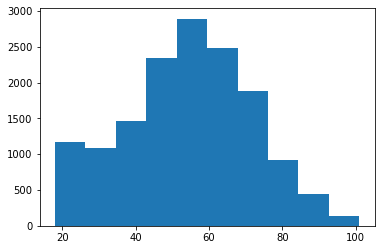

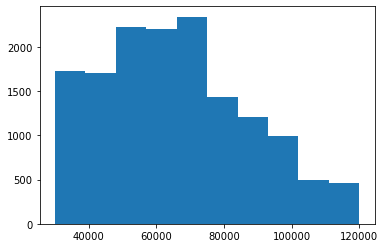

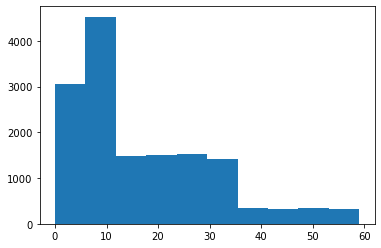

In [27]:
# From a glance, it doesn't look like there are any outliers to be concerned about.
plt.figure()
plt.hist(profile['age'])
plt.figure()
plt.hist(profile['income'])
plt.figure()
plt.hist(profile['months_since_member'])

# Creating summary dataframe

### Determining successful offer responses
Here, the offer_events dataframe is used to create a dataframe that marks whether each of the 4 BOGO or 4 discount offers were successfully completed, based on the criteria that offer received, offer viewed and offer completed events are present for the offer.

An assumption is made here that all offer completed events are before expiry_date = offer_received_day + offer_duration

In [28]:
def add_dummies(df, col):
    """
    This function adds dummy columns to the input dataframe
    Input: df - the dataframe
           col - the label of the column of interest, string
    Output: df with added dummy columns
    """
    return pd.get_dummies(df,columns=[col],prefix='',prefix_sep='')

#Add an extra column to offer_events, event_offer_id, consisting of 'event'_'offer_id'
BOGO_or_discs = offer_events[(offer_events['offer_id'] != 'informational_B') & (offer_events['offer_id'] != 'informational_A')]
BOGO_or_discs['event_offer_id'] = BOGO_or_discs['event'] + '_' + BOGO_or_discs['offer_id']

offer_list = list(np.sort(BOGO_or_discs['offer_id'].unique()))

#Create dummy variables for the event_offer_id_column
BOGO_or_discs = add_dummies(BOGO_or_discs,'event_offer_id')

#Sum up all rows corresponding to the same customer id
mark_customer_response = BOGO_or_discs.groupby('customer_id',as_index=False).sum().drop(columns=['time'])

#Reduce all records where the value is more than 1 to 1.
mark_customer_response[mark_customer_response.columns.difference(['customer_id'])] = \
mark_customer_response[mark_customer_response.columns.difference(['customer_id'])].applymap(lambda x: 1 if x > 1 else x)

#Loop through each offer ID
for offer_id in offer_list:
    events = ['offer received_' + offer_id,\
              'offer viewed_'   + offer_id,\
              'offer completed_'+ offer_id]
    
    #sum up offer received, offer viewed and offer completed columns. If all 3 events are present (sum = 3), mark as 1, else 0
    mark_customer_response['success_'+offer_id] = mark_customer_response[events].sum(axis=1)
    mark_customer_response.loc[(mark_customer_response['success_'+offer_id] < 3),'success_'+offer_id] = 0
    mark_customer_response.loc[(mark_customer_response['success_'+offer_id] == 3),'success_'+offer_id] = 1
    
    #remove columns corresponding to events
    mark_customer_response = mark_customer_response.drop(columns=events)
    
#BOGO success
mark_customer_response['success_BOGO'] = mark_customer_response[['success_BOGO_A','success_BOGO_B','success_BOGO_C','success_BOGO_D']].sum(axis=1)
#discount success
mark_customer_response['success_discount'] = mark_customer_response[['success_discount_A','success_discount_B','success_discount_C','success_discount_D']].sum(axis=1)
#offer success
mark_customer_response['success_offer'] = mark_customer_response[['success_BOGO','success_discount']].sum(axis=1)

#Keep only above 3 columns
mark_customer_response = mark_customer_response[['customer_id','success_BOGO','success_discount','success_offer']]

#Reduce entries for these columns that are > 1 to 1
mark_customer_response[['success_BOGO','success_discount','success_offer']] = \
mark_customer_response[['success_BOGO','success_discount','success_offer']].applymap(lambda x: 1 if x > 1 else x)


<ipython-input-28-9095a1eea62e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BOGO_or_discs['event_offer_id'] = BOGO_or_discs['event'] + '_' + BOGO_or_discs['offer_id']


In [29]:
display(mark_customer_response['success_BOGO'].value_counts(),\
        mark_customer_response['success_discount'].value_counts(),\
        mark_customer_response['success_offer'].value_counts())

0    8486
1    8442
Name: success_BOGO, dtype: int64

1    9290
0    7638
Name: success_discount, dtype: int64

1    12202
0     4726
Name: success_offer, dtype: int64

### Getting average transaction per customer

In [30]:
ave_spend = transactions.groupby('customer_id',as_index=False).mean()[['customer_id','amount']]

### Merging dataframes together to create the summary dataframe

In [31]:
customer_summary = profile.merge(ave_spend, how='left', on='customer_id' )
customer_summary = customer_summary.merge(mark_customer_response, how='left', on='customer_id')

### Cleaning summary dataframe

In [32]:
#Determine which columns have null values
customer_summary.isnull().sum()

gender                   0
age                      0
became_member_on         0
income                   0
months_since_member      0
customer_id              0
amount                 333
success_BOGO            61
success_discount        61
success_offer           61
dtype: int64

In [33]:
#If amount is Null, it means there was no spend. These customers will not have responded to any offers.
#Drop nulls
customer_summary = customer_summary.dropna()

In [34]:
#Viewing the complete customer_summary dataframe
customer_summary

,gender,age,became_member_on,income,months_since_member,customer_id,amount,success_BOGO,success_discount,success_offer
0,F,55,2017-07-15,112000.0,12,2,25.670000,0.0,0.0,0.0
1,F,75,2017-05-09,100000.0,14,4,22.752857,1.0,0.0,1.0
2,M,68,2018-04-26,70000.0,3,6,19.243333,1.0,1.0,1.0
3,M,65,2018-02-09,53000.0,5,9,12.143333,1.0,1.0,1.0
4,M,58,2017-11-11,51000.0,8,13,3.905000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
14820,F,45,2018-06-04,54000.0,1,16996,2.861429,0.0,0.0,0.0
14821,M,61,2018-07-13,72000.0,0,16997,3.710000,0.0,0.0,0.0
14822,M,49,2017-01-26,73000.0,18,16998,4.967500,0.0,0.0,0.0
14823,F,83,2016-03-07,50000.0,28,16999,13.547857,1.0,0.0,1.0


In [35]:
#Output customer_summary for creating figures
customer_summary.to_csv('customer_summary.csv', index=False)

# Data Analysis

Having processed the data in a meaningful way, we can now make some analyses of the data

### Preliminary analysis

Text(1.5, 1.2, 'Average transaction spend vs. Income')

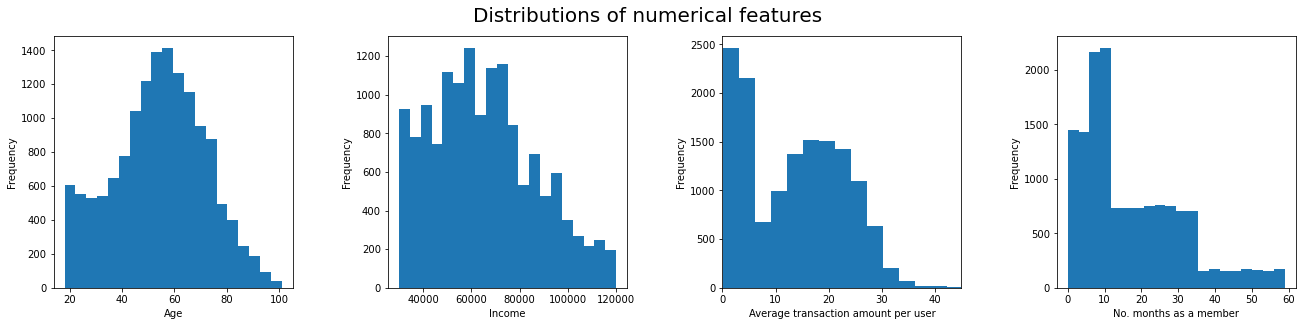

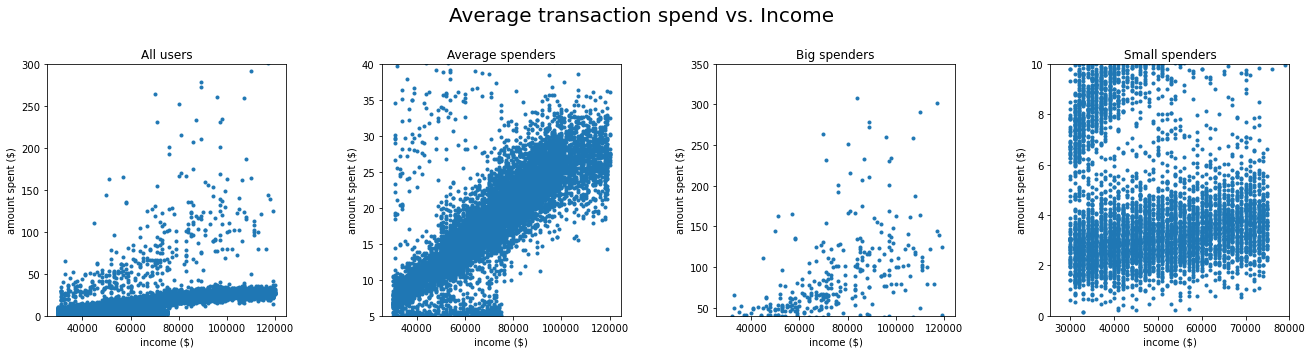

In [36]:
# Visualize the distribution of the age, income, and year of becoming member of the customers
fig, axis = plt.subplots(1, 4)
plt.subplots_adjust(wspace=0.4, hspace=0.8, top=1.0, right=3)

#Plot
ax_1 = customer_summary['age'].plot.hist(ax=axis[0], bins=20)
ax_2 = customer_summary['income'].plot.hist(ax=axis[1], bins=20)
ax_3 = customer_summary['amount'].plot.hist(ax=axis[2], bins=150)
ax_4 = customer_summary['months_since_member'].plot.hist(ax=axis[3], bins=20)

#Set labels
ax_1.set_xlabel('Age')
ax_2.set_xlabel('Income')
ax_3.set_xlabel('Average transaction amount per user')
ax_3.set_xlim([0, 45])
ax_4.set_xlabel('No. months as a member')
fig.suptitle('Distributions of numerical features',x=1.5,y=1.1, fontsize=20)

# Visualize ave. transaction amount vs income for 4 different x and y ranges
fig, axis = plt.subplots(1, 4)
plt.subplots_adjust(wspace=0.4, hspace=0.8, top=1.0, right=3)
axis[0].plot(customer_summary['income'],customer_summary['amount'],'.')
axis[0].set_xlabel('income ($)')
axis[0].set_ylabel('amount spent ($)')
axis[0].set_ylim([0,300])
axis[0].set_title('All users')

axis[1].plot(customer_summary['income'],customer_summary['amount'],'.')
axis[1].set_xlabel('income ($)')
axis[1].set_ylabel('amount spent ($)')
axis[1].set_title('Average spenders')
axis[1].set_ylim([5,40])

axis[2].plot(customer_summary['income'],customer_summary['amount'],'.')
axis[2].set_xlabel('income ($)')
axis[2].set_ylabel('amount spent ($)')
axis[2].set_title('Big spenders')
axis[2].set_ylim([40,350])

axis[3].plot(customer_summary['income'],customer_summary['amount'],'.')
axis[3].set_xlabel('income ($)')
axis[3].set_ylabel('amount spent ($)')
axis[3].set_ylim([0,10])
axis[3].set_title('Small spenders')
axis[3].set_xlim(right=80000)
fig.suptitle('Average transaction spend vs. Income',x=1.5,y=1.2, fontsize=20)

In [37]:
#Ratios of the different genders
customer_summary.groupby(['gender']).count()['age']/customer_summary.shape[0]

gender
F    0.413468
M    0.572468
O    0.014064
Name: age, dtype: float64

In [38]:
#Response % by offer type
customer_summary[['success_BOGO','success_discount','success_offer']].sum(axis=0)/customer_summary.shape[0]

success_BOGO        0.563600
success_discount    0.605515
success_offer       0.793404
dtype: float64

### Observations

**Distribution of numerical features**
- Interestingly, most of the customers are between 40 to 80 years old. 
- The main income range of the customers is within 40k-80k dollars (not unexpected).
- There appears to be two peaks in average transaction amount: < ~5 dollars and ~15 - 25 dollars. 
- Members appear to fall into 1 of 3 groups: approx. 0 - 12 months, 12 to 35 months and 35+ months

**Average transaction spend vs. income**
- From a glance, it appears that amount spent is correlated with income
- It appears that users fall into 1 of 3 groups:
    - Big spenders: individuals who on average spend ~40 dollars or more. Amount spent appears to be linearly correlated with income.
    - Small spenders: individuals who on average spend ~6 dollars or less. Amount spent appears to be linearly correlated with income.
    - Average spenders: individuals who spend ~7 to 40 dollars. Majority of users fall in this group. Spending appears to be linearly correlated with income up to an income of ~100000 dollars; beyond this point spending plateaus at ~30 dollars.


**Other**
- Males make up a majority of users, while 'other' makes up less than 2%
- 55% of users responded to BOGO offers, 59% responded to discount offers, and 77% responded to at least one of the two offer types. This makes discount offers slightly more successful, but it appears that there may also be a demographic that responds better to BOGO.

It may be interesting to follow some of these leads to further our analysis

### Statistical testing: Equal variance or Unequal variance t-testing

In the following sections, I attempt to understand which groups respond better to offers than others based on the some of the above observations. To make a decision on whether there was any differences in responsiveness to offers between groups, I employed two types of t-test, for equal and unequal variances (Welch's t-test)

Read more [here](https://www.investopedia.com/terms/t/t-test.asp)

The statistical testing was conducted based on the following flow:
1. Determine if variances between groups are same or different using [Levene's test](https://www.statology.org/levenes-test-python/). This test is chosen because values within the groups do not need to be normally distributed (When using the median) 
2. Apply the appropriate test based on the outcome of step 1.

In [39]:
def t_test(group_1, group_2):
    """
        This function 
        1. Determines if variances of group 1 and group are equal
        2. If:
            a. Equal, uses equal variances t-test
            b. Unequal, uses welch's t-test

        The assumption is that the mean of group 1 > mean of group 2
        Input: group_1 : group 1 values, list
               group_2 : group 2 values, list
        Output: None
    """
    print("group_1 mean: {}, group_2 mean: {}".format(np.mean(group_1),np.mean(group_2)))
    var_diff = stats.levene(group_1, group_2,\
                 center='median')[1] #Here I use the median, as there is no assumption that the distributions of group 1 or 2 are normal.

    if var_diff < 0.05: #Welch's t-test
        print("Variances of group 1 and 2 are different, Welch's t-test is used. Levene's test p-score: {}".format(var_diff))
        diff_test = stats.ttest_ind(a=group_1, b=group_2, alternative='greater',\
                    equal_var=False)[1]
    else:
        print("Variances of group 1 and 2 are the same, equal-variance t-test is be used. Levene's test p-score: {}".format(var_diff))
        diff_test = stats.ttest_ind(a=group_1, b=group_2, alternative='greater',\
                    equal_var=True)[1]

    if diff_test < 0.05:
        print("The difference between the means of group_1 and group_2 is statistically significant. p-score: {}".format(diff_test))
    else:
        print("The difference between the means of group_1 and group_2 is NOT statistically significant. p-score: {}".format(diff_test))

### How does offer response differ by age?



success_BOGO age differences
group_1 mean: 55.946896127842656, group_2 mean: 52.19415780282584
Variances of group 1 and 2 are different, Welch's t-test is used. Levene's test p-score: 1.325536113837955e-20
The difference between the means of group_1 and group_2 is statistically significant. p-score: 2.0285814492337802e-37

success_discount age differences
group_1 mean: 55.18604118993135, group_2 mean: 52.96329469617141
Variances of group 1 and 2 are different, Welch's t-test is used. Levene's test p-score: 5.059933760404485e-09
The difference between the means of group_1 and group_2 is statistically significant. p-score: 6.694653588890156e-14

success_offer age differences
group_1 mean: 55.232623122598675, group_2 mean: 50.762910798122064
Variances of group 1 and 2 are different, Welch's t-test is used. Levene's test p-score: 5.907507828771867e-19
The difference between the means of group_1 and group_2 is statistically significant. p-score: 1.371298322256363e-32



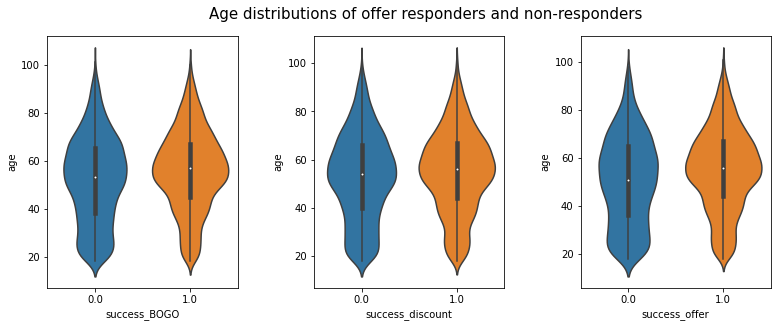

In [40]:
#Plot distributions of age for offer responders and non-responders
fig, axis = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.4, hspace=0.8, top=1.0, right=1.8)

ax_1 = sns.violinplot(y='age', 
                x='success_offer', 
                data=customer_summary,
                ax=axis[2])

ax_2 = sns.violinplot(y='age', 
                x='success_discount', 
                data=customer_summary,
                ax=axis[1])

ax_3 = sns.violinplot(y='age', 
                x='success_BOGO', 
                data=customer_summary,
                ax=axis[0])

fig.suptitle('Age distributions of offer responders and non-responders',x=1,y=1.1, fontsize=15)

#Performing t-testing to confirm statistical significance
for offer in ['success_BOGO','success_discount','success_offer']:
    
    print("{} age differences".format(offer))
    t_test(customer_summary[customer_summary[offer]==1]['age'],\
           customer_summary[customer_summary[offer]==0]['age'])
    print("")

### How much do users who do and do not respond to offers spend?

success_BOGO spending pattern differences
group_1 mean: 18.894932976514436, group_2 mean: 10.569025548470497
Variances of group 1 and 2 are the same, equal-variance t-test is be used. Levene's test p-score: 0.20987758777586937
The difference between the means of group_1 and group_2 is statistically significant. p-score: 1.3969033193291977e-203

success_discount spending pattern differences
group_1 mean: 17.39369827374999, group_2 mean: 11.988698416084548
Variances of group 1 and 2 are the same, equal-variance t-test is be used. Levene's test p-score: 0.16194509721129643
The difference between the means of group_1 and group_2 is statistically significant. p-score: 4.085003537732313e-83

success_offer spending pattern differences
group_1 mean: 17.390186563596224, group_2 mean: 7.0865711493820704
Variances of group 1 and 2 are different, Welch's t-test is used. Levene's test p-score: 1.460643142865267e-39
The difference between the means of group_1 and group_2 is statistically significant

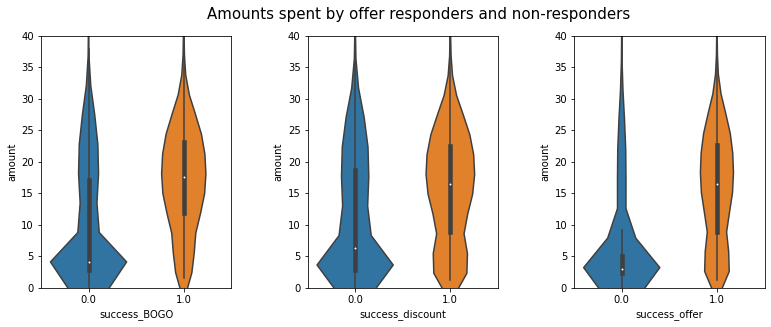

In [41]:
#Plot distributions of ave. amount spent for offer responders and non-responders
fig, axis = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.4, hspace=0.8, top=1.0, right=1.8)

ax_1 = sns.violinplot(y='amount', 
                x='success_offer', 
                data=customer_summary,
                ax=axis[2])

ax_2 = sns.violinplot(y='amount', 
                x='success_discount', 
                data=customer_summary,
                ax=axis[1])

ax_3 = sns.violinplot(y='amount', 
                x='success_BOGO', 
                data=customer_summary,
                ax=axis[0])

fig.suptitle('Amounts spent by offer responders and non-responders',x=1,y=1.1, fontsize=15)

ax_3.set_ylim([0, 40])
ax_2.set_ylim([0, 40])
ax_1.set_ylim([0, 40])

#Performing t-testing to confirm statistical significance
for offer in ['success_BOGO','success_discount','success_offer']:
    
    print("{} spending pattern differences".format(offer))
    t_test(customer_summary[customer_summary[offer]==1]['amount'],\
           customer_summary[customer_summary[offer]==0]['amount'])
    print("")

### How does offer response differ by income?

success_BOGO income differences
group_1 mean: 69627.28948985864, group_2 mean: 59546.43594221305
Variances of group 1 and 2 are different, Welch's t-test is used. Levene's test p-score: 3.412592849039894e-08
The difference between the means of group_1 and group_2 is statistically significant. p-score: 9.779283264251322e-177

success_discount income differences
group_1 mean: 67750.0, group_2 mean: 61356.866877414825
Variances of group 1 and 2 are the same, equal-variance t-test is be used. Levene's test p-score: 0.17603573652117682
The difference between the means of group_1 and group_2 is statistically significant. p-score: 1.291064131229819e-68

success_offer income differences
group_1 mean: 67964.72231924554, group_2 mean: 54717.97451374916
Variances of group 1 and 2 are different, Welch's t-test is used. Levene's test p-score: 1.7439192319130709e-46
The difference between the means of group_1 and group_2 is statistically significant. p-score: 7.701736192124924e-236



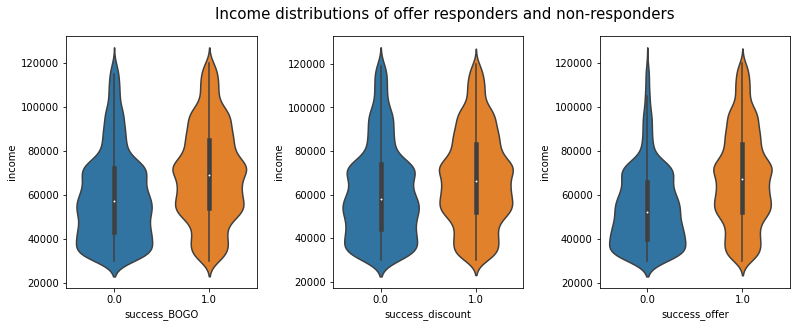

In [42]:
#Plot income distributions for offer responders and non-responders
fig, axis = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.4, hspace=0.8, top=1.0, right=1.8)

ax_1 = sns.violinplot(y='income', 
                x='success_offer', 
                data=customer_summary,
                ax=axis[2])

ax_2 = sns.violinplot(y='income', 
                x='success_discount', 
                data=customer_summary,
                ax=axis[1])

ax_3 = sns.violinplot(y='income', 
                x='success_BOGO', 
                data=customer_summary,
                ax=axis[0])

fig.suptitle('Income distributions of offer responders and non-responders',x=1,y=1.1, fontsize=15)

#Performing t-testing to confirm statistical significance
for offer in ['success_BOGO','success_discount','success_offer']:
    
    print("{} income differences".format(offer))
    t_test(customer_summary[customer_summary[offer]==1]['income'],\
           customer_summary[customer_summary[offer]==0]['income'])
    print("")

### Observations

**Age vs. offer response**

From a quick glance of the violin charts, age distributions of responders to the BOGO offers, discount offers or either type of offer are similar, although the median ages of responders appear to be slightly higher.
From the statistical tests, the age difference between responders and non-responders is slight but statistically significant.

**Average amount spent vs. offer response**

The distribution of the average amount spent by responders and non-responders appears to be quite significantly different.
Users who respond to offers tend to be slightly bigger spenders (average spending is about 6+ dollars more). However, it is also possible that the offer is leading the user to spend more than they usually would.

**Income vs. offer response**

The income differences between responders and non-responders is noticeable - individuals with higher incomes are more likely to respond to offers of either kind. However, from the preliminary analysis earlier, we found that there exists 3 different correlations between average amount spent and income. As such, further investigation of income vs offer response within each of the 3 spending groups (high spenders, average spenders, low spenders) may be necessary.

### Splitting users into groups based on the relationship between average amount spent vs. income

Customers were split into groups A, B and C empirically based on the relationship between average spend and income
- A: Big spenders
- B: Average spenders
- C: Small spenders

In [43]:
def lin_equ(l1, l2):
    """
        Function for calculating m and c in y=mx+c for two points
        
        Inputs l1, l2: lists or sets of form (x,y)
        Outputs: m & c (float)
    """
    
    m = (l2[1] - l1[1]) / (l2[0] - l1[0])
    c = (l2[1] - (m * l2[0]))
    return m, c

**Transformation: Add extra column containing labels A, B, and C**

Text(0.5, 1.0, 'Clustered')

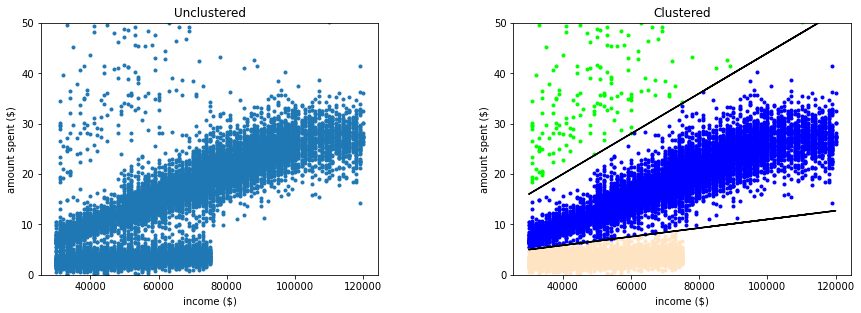

In [44]:
#Start by setting all users to big spenders
customer_summary['spending_pattern'] = 'A'

#Boundary 1
m1, c1 = lin_equ((30000,16),(90000,40))

#Set users below boundary 1 to average spenders
customer_summary.loc[customer_summary['amount'] < (m1*customer_summary['income'] + c1),'spending_pattern'] = 'B'

#Boundary 2
m2, c2 = lin_equ((30000,5),(65000,8))

#Set users below boundary 2 to small spenders
customer_summary.loc[customer_summary['amount'] < (m2*customer_summary['income'] + c2),'spending_pattern'] = 'C'

###################Plotting subplots
fig, axis = plt.subplots(1, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.8, top=1.0, right=2)

#Left plot
axis[0].plot(customer_summary['income'],customer_summary['amount'],'.')
axis[0].set_xlabel('income ($)')
axis[0].set_ylabel('amount spent ($)')
axis[0].set_ylim([0,50])
axis[0].set_title('Unclustered')

#Right plot
axis[1].plot(customer_summary[customer_summary['spending_pattern']=='A']['income'],\
             customer_summary[customer_summary['spending_pattern']=='A']['amount'],'.',color='lime')
axis[1].plot(customer_summary[customer_summary['spending_pattern']=='B']['income'],\
             customer_summary[customer_summary['spending_pattern']=='B']['amount'],'.',color='blue')
axis[1].plot(customer_summary[customer_summary['spending_pattern']=='C']['income'],\
             customer_summary[customer_summary['spending_pattern']=='C']['amount'],'.',color='bisque')
axis[1].plot(customer_summary['income'],m2*customer_summary['income'] + c2,'-',color='black')
axis[1].plot(customer_summary['income'],m1*customer_summary['income'] + c1,'-',color='black')
axis[1].set_ylim([0,50])
axis[1].set_xlabel('income ($)')
axis[1].set_ylabel('amount spent ($)')
axis[1].set_ylim([0,50])
axis[1].set_title('Clustered')


### How does offer response differ by spending pattern group?

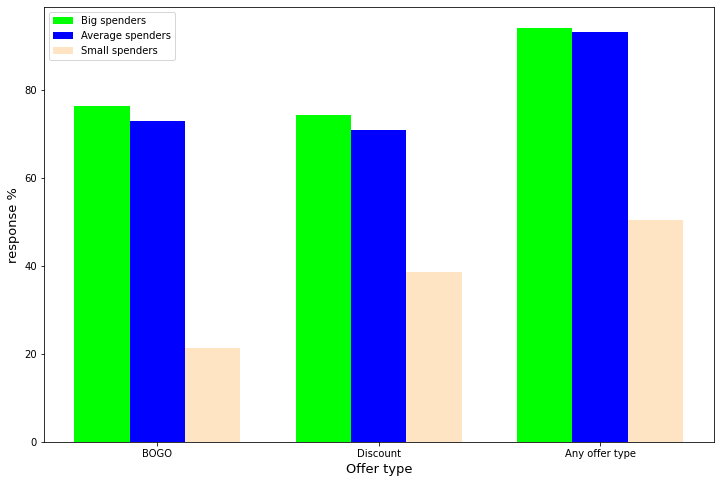

In [45]:
# set width of bar 
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8)) 
 
# set height of bar 
group_0 = customer_summary[customer_summary['spending_pattern']=='A']
group_1 = customer_summary[customer_summary['spending_pattern']=='B']
group_2 = customer_summary[customer_summary['spending_pattern']=='C']

plot_group_0 = [100*group_0['success_BOGO'].sum()/group_0.shape[0],\
                100*group_0['success_discount'].sum()/group_0.shape[0],\
                100*group_0['success_offer'].sum()/group_0.shape[0]]

plot_group_1 = [100*group_1['success_BOGO'].sum()/group_1.shape[0],\
                100*group_1['success_discount'].sum()/group_1.shape[0],\
                100*group_1['success_offer'].sum()/group_1.shape[0]]

plot_group_2 = [100*group_2['success_BOGO'].sum()/group_2.shape[0],\
                100*group_2['success_discount'].sum()/group_2.shape[0],\
                100*group_2['success_offer'].sum()/group_2.shape[0]]
 
# Set position of bar on X axis 
br1 = np.arange(len(plot_group_0)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
 
# Make the plot
plt.bar(br1, plot_group_0, color ='lime', width = barWidth, label ='Big spenders') 
plt.bar(br2, plot_group_1, color ='blue', width = barWidth, label ='Average spenders') 
plt.bar(br3, plot_group_2, color ='bisque', width = barWidth,  label ='Small spenders') 
 
# Adding Xticks 
plt.xlabel('Offer type', fontsize = 13) 
plt.ylabel('response %', fontsize = 13) 
plt.xticks([r + barWidth for r in range(len(plot_group_0))], 
        ['BOGO', 'Discount', 'Any offer type'])
 
plt.legend()
plt.show() 

### Observations

- Small spenders have a low likelihood of responding to discount offers and are even more unlikely to respond to BOGO offers.

- Interestingly Big and Average spenders have almost 80% response rate to either offer type

### How does offer response differ by membership duration?
As explained previously it looks like there are 3 distinct groups of membership duration. While I approximately determined the cutoffs of the 3 groups, here I use a more algorithmic approach to deciding the cutoff points of each group.

**Transformation: Adding extra column containing labels 0, 1, 2 to mark which membership duration group they belong to**

In [46]:
#Perform 1D clustering to identify the 3 clusters and their boundaries
k = 3
x = list(customer_summary['months_since_member'])
customer_summary['months_member_cluster'] = kmeans1d.cluster(list(customer_summary['months_since_member']), k)[0]


display(customer_summary[customer_summary['months_member_cluster'] == 0]['months_since_member'].describe(),\
        customer_summary[customer_summary['months_member_cluster'] == 1]['months_since_member'].describe(),\
        customer_summary[customer_summary['months_member_cluster'] == 2]['months_since_member'].describe())

count    8459.000000
mean        7.244946
std         4.218501
min         0.000000
25%         4.000000
50%         7.000000
75%        10.000000
max        16.000000
Name: months_since_member, dtype: float64

count    4764.000000
mean       26.117758
std         5.588502
min        17.000000
25%        21.000000
50%        26.000000
75%        31.000000
max        37.000000
Name: months_since_member, dtype: float64

count    1211.000000
mean       48.466557
std         6.376441
min        38.000000
25%        43.000000
50%        49.000000
75%        54.000000
max        59.000000
Name: months_since_member, dtype: float64

Above, we can see that users hat have been members for 16 months or less are part of **group 0** (59%), users who have been members for 17 to 37  months fall into **group 1** (32%), and users who have been members for 38 months or more are in **group 2** (8%). Perhaps cutoff points correspond to events in the history of the starbucks membership program.

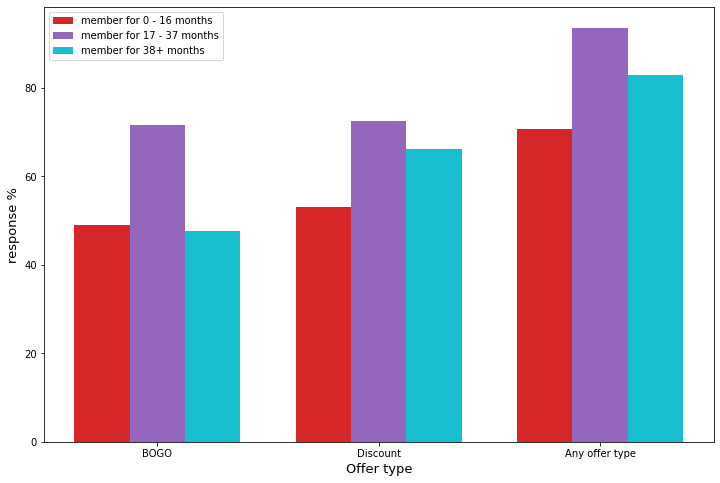

In [47]:
# set width of bar 
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8)) 
 
# set height of bar 
group_0 = customer_summary[customer_summary['months_member_cluster'] == 0]
group_1 = customer_summary[customer_summary['months_member_cluster'] == 1]
group_2 = customer_summary[customer_summary['months_member_cluster'] == 2]

plot_group_0 = [100*group_0['success_BOGO'].sum()/group_0.shape[0],\
                100*group_0['success_discount'].sum()/group_0.shape[0],\
                100*group_0['success_offer'].sum()/group_0.shape[0]]

plot_group_1 = [100*group_1['success_BOGO'].sum()/group_1.shape[0],\
                100*group_1['success_discount'].sum()/group_1.shape[0],\
                100*group_1['success_offer'].sum()/group_1.shape[0]]

plot_group_2 = [100*group_2['success_BOGO'].sum()/group_2.shape[0],\
                100*group_2['success_discount'].sum()/group_2.shape[0],\
                100*group_2['success_offer'].sum()/group_2.shape[0]]
 
# Set position of bar on X axis 
br1 = np.arange(len(plot_group_0)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
 
# Make the plot
plt.bar(br1, plot_group_0, color ='tab:red', width = barWidth, label ='member for 0 - 16 months') 
plt.bar(br2, plot_group_1, color ='tab:purple', width = barWidth, label ='member for 17 - 37 months') 
plt.bar(br3, plot_group_2, color ='tab:cyan', width = barWidth,  label ='member for 38+ months') 
 
# Adding Xticks 
plt.xlabel('Offer type', fontsize = 13) 
plt.ylabel('response %', fontsize = 13) 
plt.xticks([r + barWidth for r in range(len(plot_group_0))], 
        ['BOGO', 'Discount', 'Any offer type'])
 
plt.legend()
plt.show() 

#### Observations

Interestingly, we can see that users that have been members for 17-37 months, which make up 32% of the users which received offers, have a responserate of ~70% for either BOGO and Discount offers, and have an overall response rate to at least one offer type of over 90%!

Users that have been members for 38+ months appear to respond more positively to discounts than BOGO offers, although have an overall response rate of over 80%.

It is not immediately obvious why users which have been members for years tend to respond more positively to offers.

### Average transaction amount across the 3 membership duration groups

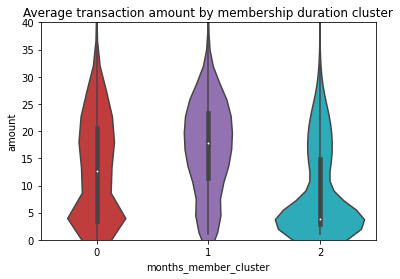

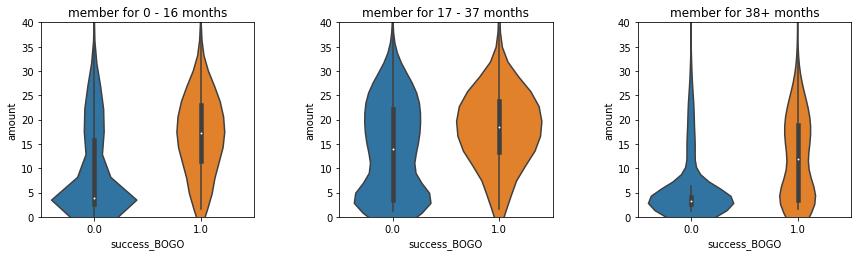

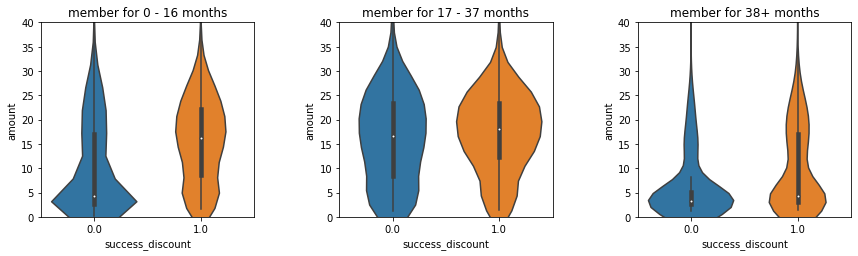

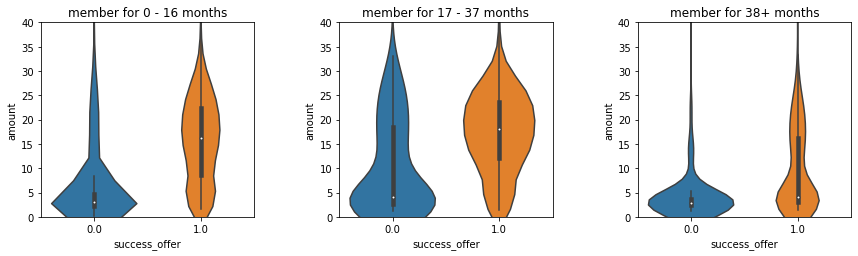

In [48]:
# Plot violin plots of amount for each of the 3 membership duration groups
plt.figure()
my_pal = {0: 'tab:red', 1: 'tab:purple', 2: 'tab:cyan'}
sns.violinplot(y='amount', 
                x='months_member_cluster', 
                data=customer_summary,
                palette=my_pal)
plt.ylim([0,40])
plt.title('Average transaction amount by membership duration cluster')

# Plot distribution of amounts spent by each membership duration group, for responders and non-responders
for i, offer in enumerate(['success_BOGO','success_discount','success_offer']):
    fig, axis = plt.subplots(1, 3)
    plt.subplots_adjust(wspace=0.4, hspace=0.4, top=0.8, right=2)
    ax_1 = sns.violinplot(y='amount', 
                x=offer, 
                data=group_0,
                ax=axis[0])
    ax_2 = sns.violinplot(y='amount', 
                x=offer, 
                data=group_1,
                ax=axis[1])

    ax_3 = sns.violinplot(y='amount', 
                x=offer, 
                data=group_2,
                ax=axis[2])
    
    ax_1.set_title('member for 0 - 16 months')
    ax_2.set_title('member for 17 - 37 months')
    ax_3.set_title('member for 38+ months')
    ax_1.set_ylim([0, 40])
    ax_2.set_ylim([0, 40])
    ax_3.set_ylim([0, 40])

#### Observations

Interestingly, users who have been members for 17 to 37 months tend to spend the most, while users who have been members for 38+ months seem to spend less.

While this is interesting behaviour, it is not immediately obvious why this might be happening.

### Creating a set of heuristics for predicting the likelihood of responding to an offer

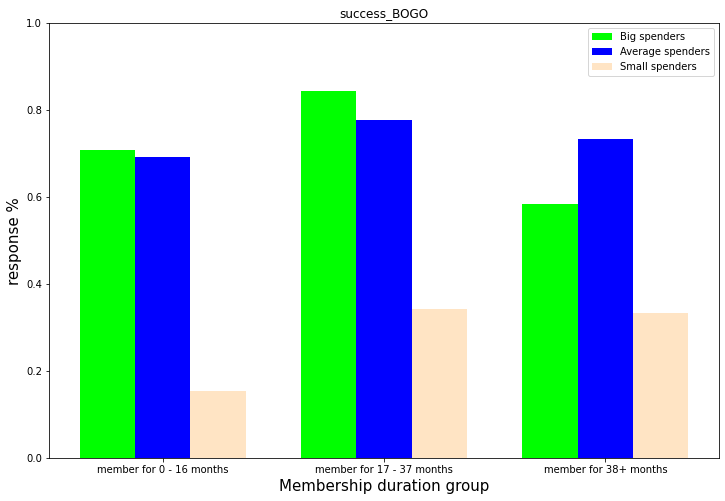

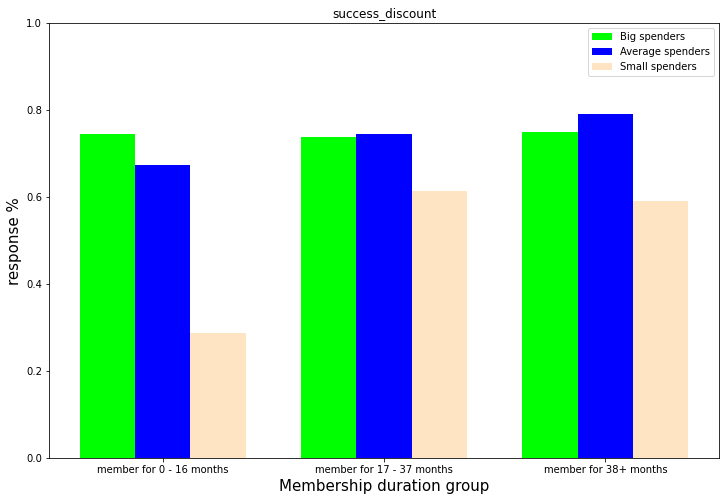

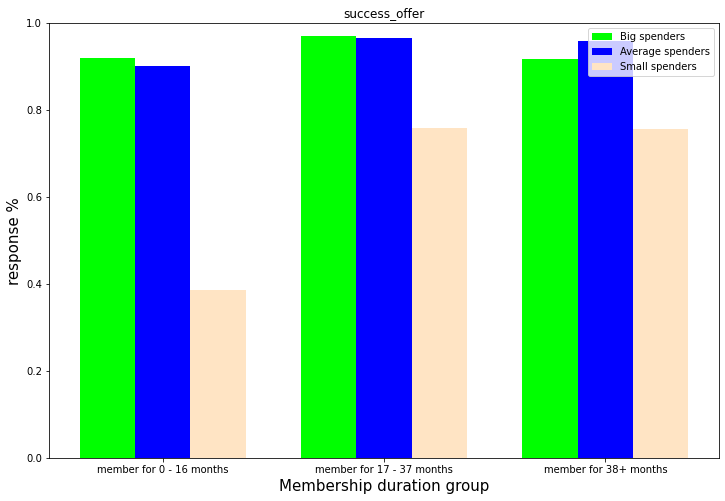

In [49]:
# Splitting users by spending behaviour and membership duration
for offer_type in ['success_BOGO','success_discount','success_offer']:
    plot_values = np.zeros((3,3))
    for i, months_member_cluster in enumerate([0, 1, 2]):
        for j, spending_pattern in enumerate(['A','B','C']):
            group = customer_summary[(customer_summary['months_member_cluster'] == months_member_cluster ) & \
                                     (customer_summary['spending_pattern'] == spending_pattern)]
            plot_values[i,j] = group[offer_type].sum()/group.shape[0]
    
    plot_group_0 = list(plot_values[:,0])
    plot_group_1 = list(plot_values[:,1])
    plot_group_2 = list(plot_values[:,2])

    # set width of bar 
    barWidth = 0.25
    fig = plt.subplots(figsize =(12, 8)) 
    
    # Set position of bar on X axis 
    br1 = np.arange(len(plot_group_0)) 
    br2 = [x + barWidth for x in br1] 
    br3 = [x + barWidth for x in br2] 
 
    # Make the plot
    plt.bar(br1, plot_group_0, color ='lime', width = barWidth, label ='Big spenders') 
    plt.bar(br2, plot_group_1, color ='blue', width = barWidth, label ='Average spenders') 
    plt.bar(br3, plot_group_2, color ='bisque', width = barWidth,  label ='Small spenders') 
    plt.ylim([0,1])
    
    # Adding Xticks
    plt.xlabel('Membership duration group', fontsize = 15) 
    plt.ylabel('response %', fontsize = 15) 
    plt.xticks([r + barWidth for r in range(len(plot_group_0))], 
            ['member for 0 - 16 months', 'member for 17 - 37 months', 'member for 38+ months'])
    plt.title(offer_type)
    plt.legend()
    plt.show() 

### Putting our heuristics to the test


BOGO offer heuristic


<Figure size 432x288 with 0 Axes>

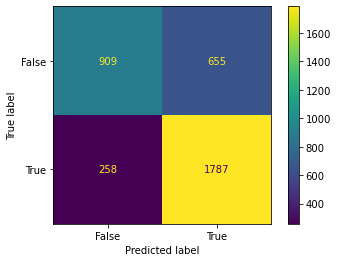

f1 score: 0.7965232895030087


In [102]:
# Applying the heuristics to BOGO offers:
# All small spenders have a low likelihood of responding to BOGO offers

#Train test split, we dont need X_train, y_train. 
#This split is done so that a fair comparison can be made with the classification models later
X_train, X_test, y_train, y_test = prepare_data(customer_summary, offer_type='BOGO',random_state=420)

y_pred = y_test.copy()
y_pred.iloc[:,:] = 1.0 #Set all values to 1.0
y_pred.loc[(X_test['C']==1),'success_BOGO'] = 0.0

print('\n{} offer heuristic'.format('BOGO'))
conf_matrix = confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
plt.figure()
cm_display.plot()
plt.show()
print('f1 score: {}'.format(f1_score(y_test,y_pred)))


discount offer heuristic


<Figure size 432x288 with 0 Axes>

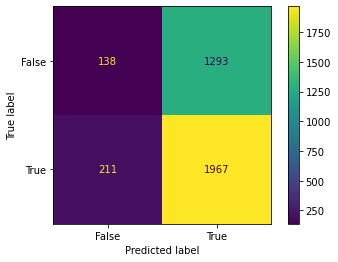

f1 score: 0.7234277307833763


In [104]:
# Applying the heuristics to discount offers
# Small spenders who have been members for 16 months or less have a low likelihood of responding to discount offers
X_train, X_test, y_train, y_test = prepare_data(customer_summary, offer_type='discount',random_state=420)

y_pred = y_test.copy()
y_pred.iloc[:,:] = 1.0 #Set all values to 1.0
y_pred.loc[(X_test['C']==1) & (X_test['months_since_member'] > 17),'success_discount'] = 0.0

print('\n{} offer heuristic'.format('discount'))
conf_matrix = confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
plt.figure()
cm_display.plot()
plt.show()
print('f1 score: {}'.format(f1_score(y_test,y_pred)))


either offer heuristic


<Figure size 432x288 with 0 Axes>

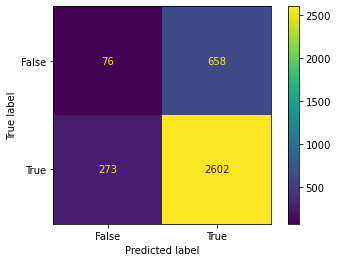

f1 score: 0.8482477587612062


In [105]:
# Applying the heuristics to success of either type of offer
# Small spenders who have been members for 16 months or less have a low likelihood of responding to either kind of offer
X_train, X_test, y_train, y_test = prepare_data(customer_summary, offer_type='either',random_state=420)

y_pred = y_test.copy()
y_pred.iloc[:,:] = 1.0 #Set all values to 1.0
y_pred.loc[(X_test['C']==1) & (X_test['months_since_member'] > 17),'success_offer'] = 0.0

print('\n{} offer heuristic'.format('either'))
conf_matrix = confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
plt.figure()
cm_display.plot()
plt.show()
print('f1 score: {}'.format(f1_score(y_test,y_pred)))

#### Observations

Using the heuristics alone, an accuracy score of ~70% for BOGO and discount offers, and an overall accuracy score of 84% was achieved.
Taking into consideration that these are simple heuristics, the accuracies of these "predictions" are quite impresive!

### Classification model development


In [53]:
def prepare_data(df,offer_type,random_state):
    """
    This function takes in customer_summary and prepares it for training.
    Specifically, it:
    1. Creates dummy variables 
    2. Removes unnecessary columns
    3. Splits into training and test sets
    
    Inputs:
    df - customer_summary dataframe
    offer_type - string - can be 'success_BOGO', 'success_discount' or 'success_offer'
    random_state - int
    
    Outputs:
    X_train, X_test, y_train, y_test - Dataframes
    """
    
    #create dummies
    df = add_dummies(df, 'gender')#.drop(columns=['O'])
    df = add_dummies(df, 'spending_pattern')#.drop(columns=['A'])
    
    #Remove unnecessary columns
    X = df.drop(columns=['became_member_on','customer_id','months_member_cluster'])
    
    if offer_type == 'BOGO':
        y = df[['success_BOGO']].astype(int)
    elif offer_type == 'discount':
        y = df[['success_discount']].astype(int)
    elif offer_type == 'either':
        y = df[['success_offer']].astype(int)
        
    #Drop Y
    X = X.drop(columns=['success_BOGO','success_discount','success_offer'])
    
    #Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random_state)
    
    return X_train, X_test, y_train, y_test

#### Logistic regression classifier
I first tried out using the logistic regression classifier because it has few parameters that need/can be tuned.


BOGO offer classification


C:\Users\thefu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Figure size 432x288 with 0 Axes>

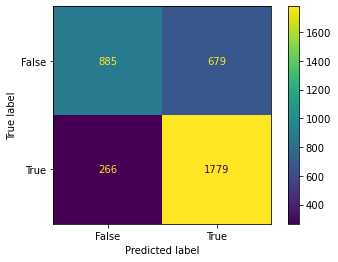

f1 score: 0.7901399067288474

discount offer classification


C:\Users\thefu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Figure size 432x288 with 0 Axes>

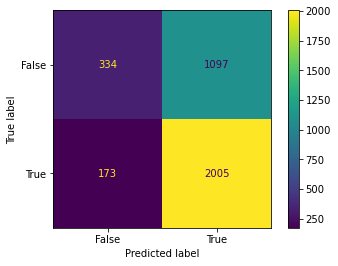

f1 score: 0.759469696969697

either offer classification


C:\Users\thefu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Figure size 432x288 with 0 Axes>

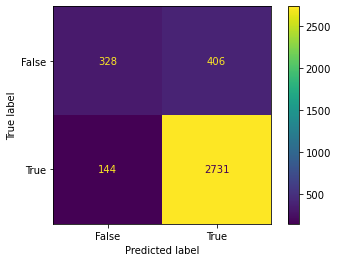

f1 score: 0.9085163007318696


In [71]:
#Using the Logistic regression classifier with default parameters
for offer_type in ['BOGO','discount', 'either']:
    classifier = LogisticRegression()

    #Train test split 
    X_train, X_test, y_train, y_test = prepare_data(customer_summary, offer_type=offer_type,random_state=420)

    # Fit the model
    classifier.fit(X_train, y_train)

    # Predict
    y_pred = classifier.predict(X_test)
    
    print('\n{} offer classification'.format(offer_type))
    conf_matrix = confusion_matrix(y_test,y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
    plt.figure()
    cm_display.plot()
    plt.show()
    print('f1 score: {}'.format(f1_score(y_test,y_pred)))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

BOGO offer classification


C:\Users\thefu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Figure size 432x288 with 0 Axes>

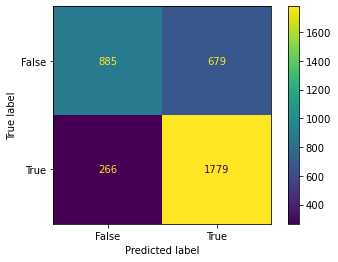

f1 score: 0.7901399067288474
Fitting 5 folds for each of 10 candidates, totalling 50 fits

discount offer classification


C:\Users\thefu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Figure size 432x288 with 0 Axes>

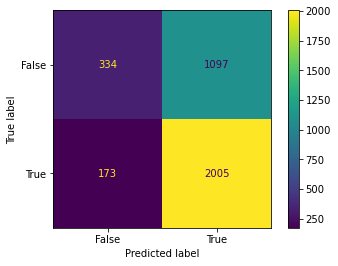

f1 score: 0.759469696969697
Fitting 5 folds for each of 10 candidates, totalling 50 fits

either offer classification


C:\Users\thefu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Figure size 432x288 with 0 Axes>

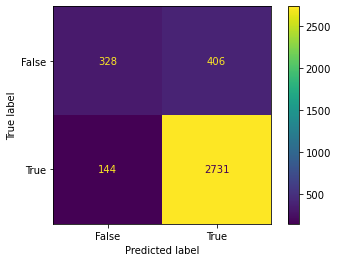

f1 score: 0.9085163007318696


In [78]:
# Use GridSearchCV to improve the classifier
param = {'C': [0.1, 0.5, 1.0, 5.0, 10.],
         'class_weight':['balanced',None]}

classifier = LogisticRegression()
search = GridSearchCV(classifier, param, cv=5, n_jobs=4, verbose=2, scoring='f1')

for offer_type in ['BOGO','discount', 'either']:
    
    #Train test split 
    X_train, X_test, y_train, y_test = prepare_data(customer_summary, offer_type=offer_type,random_state=420)

    # Fit  
    search.fit(X_train, y_train)

    # Predict
    y_pred = search.predict(X_test)

    # Test the model
    print('\n{} offer classification'.format(offer_type))
    conf_matrix = confusion_matrix(y_test,y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
    plt.figure()
    cm_display.plot()
    plt.show()
    print('f1 score: {}'.format(f1_score(y_test,y_pred)))

#### Observations

There was absolutely no difference in f1 score before and after.

#### Random forest
This classifier was chosen as it lies between XGBoost and Logistic regression in complexity and classification ability

<ipython-input-75-156a15635ace>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X_train, y_train)



BOGO offer classification


<Figure size 432x288 with 0 Axes>

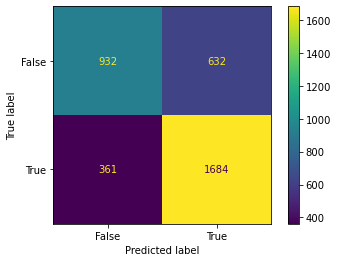

f1 score: 0.7722999312084384


<ipython-input-75-156a15635ace>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X_train, y_train)



discount offer classification


<Figure size 432x288 with 0 Axes>

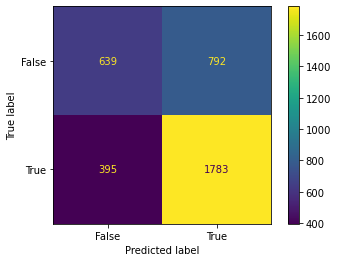

f1 score: 0.7502629917946559


<ipython-input-75-156a15635ace>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X_train, y_train)



either offer classification


<Figure size 432x288 with 0 Axes>

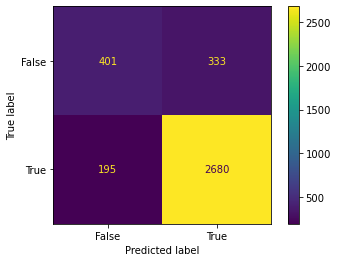

f1 score: 0.9103260869565217


In [75]:
#Using the random forst classifier with default parameters
for offer_type in ['BOGO','discount', 'either']:
    classifier = RandomForestClassifier()

    #Train test split 
    X_train, X_test, y_train, y_test = prepare_data(customer_summary, offer_type=offer_type,random_state=420)

    # Fit the model
    classifier.fit(X_train, y_train)

    # Predict
    y_pred = classifier.predict(X_test)
    
    print('\n{} offer classification'.format(offer_type))
    conf_matrix = confusion_matrix(y_test,y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
    plt.figure()
    cm_display.plot()
    plt.show()
    print('f1 score: {}'.format(f1_score(y_test,y_pred)))

Fitting 5 folds for each of 60 candidates, totalling 300 fits

BOGO offer classification


C:\Users\thefu\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


<Figure size 432x288 with 0 Axes>

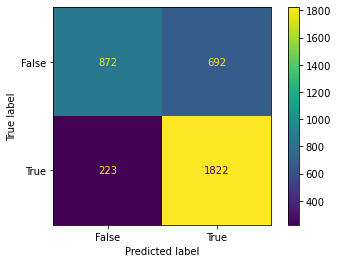

f1 score: 0.7992980916867733
Fitting 5 folds for each of 60 candidates, totalling 300 fits


C:\Users\thefu\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)



discount offer classification


<Figure size 432x288 with 0 Axes>

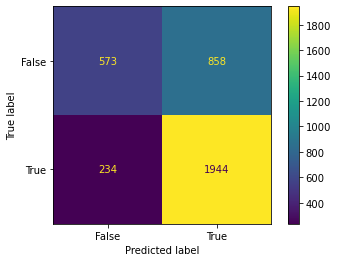

f1 score: 0.7807228915662651
Fitting 5 folds for each of 60 candidates, totalling 300 fits


C:\Users\thefu\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)



either offer classification


<Figure size 432x288 with 0 Axes>

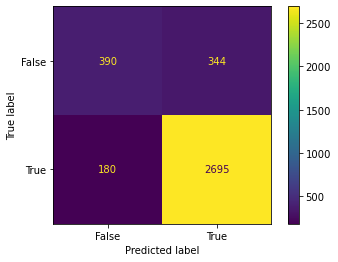

f1 score: 0.9113966858302334


In [82]:
# Use GridSearchCV to improve the classifier
param = {'n_estimators': [10, 50, 100, 200],
         'max_depth': [None, 5, 10, 15, 20],
         'max_features': ['sqrt', 'log2', None],
         'n_jobs' = [-1]
        }

classifier = RandomForestClassifier()
search = GridSearchCV(classifier, param, cv=5, n_jobs=4, verbose=2,scoring='f1')

for offer_type in ['BOGO','discount', 'either']:
    
    #Train test split 
    X_train, X_test, y_train, y_test = prepare_data(customer_summary, offer_type=offer_type,random_state=420)

    # Fit  
    search.fit(X_train, y_train)

    # Predict
    y_pred = search.predict(X_test)

    # Test the model
    print('\n{} offer classification'.format(offer_type))
    conf_matrix = confusion_matrix(y_test,y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
    plt.figure()
    cm_display.plot()
    plt.show()
    print('f1 score: {}'.format(f1_score(y_test,y_pred)))
    print('best params: {}'.format(searh.best_params_))

#### Observations
We can see that the default model performs slightly worse than logistic regression for discount and BOGO offer response prediction, but slightly better for predicting the response for either offer.

After optimization, it performs noticeably better than logistic regression for all predictions!

However, the wait time is about 10 minutes... A more efficient optimization algorithm is needed

#### XGBoost classifier
I played around a bit with this in the NLP disaster messages pipeline, and it performed quite well. As such, I was interested to see how it would perform here


BOGO offer classification


<Figure size 432x288 with 0 Axes>

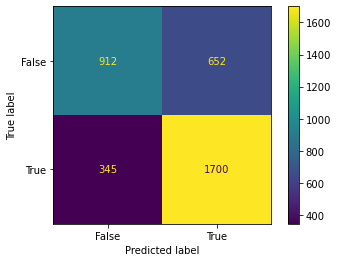

f1 score: 0.7732544916988857

discount offer classification


<Figure size 432x288 with 0 Axes>

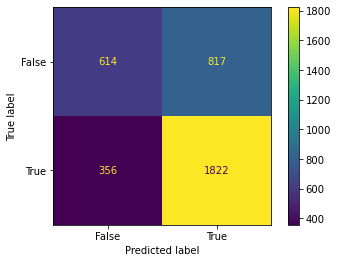

f1 score: 0.756487440315549

either offer classification


<Figure size 432x288 with 0 Axes>

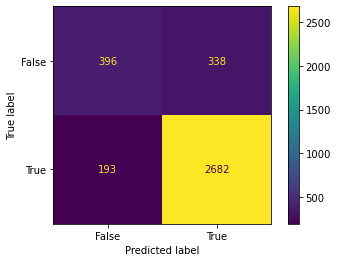

f1 score: 0.9099236641221374


In [83]:
#Using vanilla XGBoost
for offer_type in ['BOGO','discount', 'either']:
    classifier = xgb.XGBClassifier()

    #Train test split 
    X_train, X_test, y_train, y_test = prepare_data(customer_summary, offer_type=offer_type,random_state=420)

    # Fit the model
    classifier.fit(X_train, y_train)

    # Predict
    y_pred = classifier.predict(X_test)
    
    print('\n{} offer classification'.format(offer_type))
    conf_matrix = confusion_matrix(y_test,y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
    plt.figure()
    cm_display.plot()
    plt.show()
    print('f1 score: {}'.format(f1_score(y_test,y_pred)))

These medium articles were referenced to implement XGBoost and hyperparameter optimization using the hyperopt library '[1](https://medium.com/@rithpansanga/optimizing-xgboost-a-guide-to-hyperparameter-tuning-77b6e48e289d)', '[2](https://towardsdatascience.com/automate-hyperparameter-tuning-with-hyperopts-for-multiple-models-22b499298a8a)'.
Hyperopt is a more efficient algorithm than GridSearchCV as it does not need to look at all possible parameter combinations. Due to the large number of parameters to tune, it is more efficient to use this optimization method


BOGO offer classification 

100%|██████████| 300/300 [02:04<00:00,  2.41trial/s, best loss: -0.8023024131060438]


<Figure size 432x288 with 0 Axes>

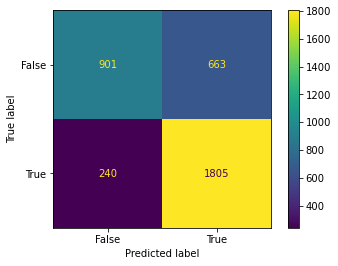

f1 score: 0.7999113671615333
Best set of hyperparameters:  {'learning_rate': 0.0398135297710612, 'max_depth': 0, 'n_estimators': 38, 'reg_alpha': 0.7736157408637633, 'reg_lambda': 0.6858227166766131, 'subsample': 0.5642386732640572}

discount offer classification 

100%|██████████| 300/300 [02:34<00:00,  1.95trial/s, best loss: -0.7826610475617097]


<Figure size 432x288 with 0 Axes>

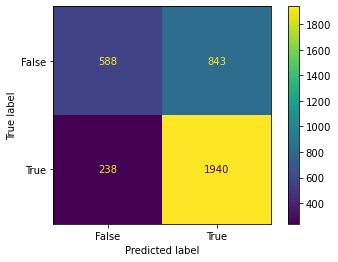

f1 score: 0.782100382987301
Best set of hyperparameters:  {'learning_rate': 0.05211938986140172, 'max_depth': 0, 'n_estimators': 39, 'reg_alpha': 0.14082182412911431, 'reg_lambda': 0.3751426910243282, 'subsample': 0.715103788221156}

either offer classification 

100%|██████████| 300/300 [01:52<00:00,  2.68trial/s, best loss: -0.9143338954468803]


<Figure size 432x288 with 0 Axes>

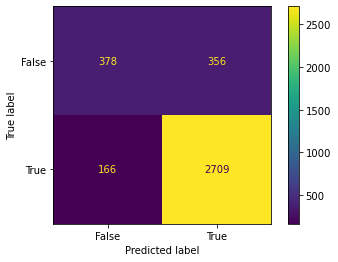

f1 score: 0.912121212121212
Best set of hyperparameters:  {'learning_rate': 0.015352331706751508, 'max_depth': 4, 'n_estimators': 8, 'reg_alpha': 0.17101867413436167, 'reg_lambda': 0.592576465902771, 'subsample': 0.5233148344119148}


In [86]:
# Define the objective function to minimize
def objective(params):
    """
        This function is used to train, evaluate and provide an f1 score that the fmin function
        aims to minimize.
        
        Input: parameters (dict)
        Output loss and status (dict)
    """
    xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    score = f1_score(y_test, y_pred)
    return {'loss': -score, 'status': STATUS_OK}

# Define the hyperparameter space
space = {
    'max_depth': hp.choice('max_depth', range(5, 30, 1)),
    'learning_rate': hp.loguniform('learning_rate', -5, -2),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'n_estimators' : hp.choice('n_estimators', range(5, 50, 1)),
    'reg_lambda' : hp.uniform ('reg_lambda', 0,1),
    'reg_alpha' : hp.uniform ('reg_alpha', 0,1),
}

#Using hyperopt to optimize XGBoost parameters
best_param_dict = {}
for offer_type in ['BOGO','discount', 'either']:
    classifier = xgb.XGBClassifier()

    #Train test split 
    X_train, X_test, y_train, y_test = prepare_data(customer_summary, offer_type=offer_type,random_state=420)

    # Perform the optimization
    print('\n{} offer classification \n'.format(offer_type))
    best_params = fmin(objective, space, algo=tpe.suggest, max_evals=300)
    
    #Perform the evaluation
    classifier = xgb.XGBClassifier(learning_rate=best_params['learning_rate'],
                                           max_depth=None,
                                           n_estimators=best_params['n_estimators'],
                                           reg_alpha=best_params['reg_alpha'],
                                           reg_lambda=best_params['reg_lambda'],
                                           subsample=best_params['subsample'])
    
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    
    
    conf_matrix = confusion_matrix(y_test,y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
    plt.figure()
    cm_display.plot()
    plt.show()
    print('f1 score: {}'.format(f1_score(y_test,y_pred)))
    print("Best set of hyperparameters: ", best_params)
    best_param_dict[offer_type] = best_params

#### Observations

The default XGBoost model performed similarly to the default random forest classifier. However, after optimization, XGBoost performed best out of all models, although by a very small margin.